# CARGA DE LIBRERIAS

In [1]:
#!pip install dill  #  Descomentar para instalar el paquete (si fuera necesario)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from copy import deepcopy

import torch
from torch import nn  # Modelos neuronales y funciones de Loss

from torch import optim # (3er paso BACKPROPAGATION) Optimizadores ---> Gradiente descendiente, Adam, AdaDelta, etc
from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # Elige el dispositivo. Utilizará GPU si está disponible

# CONSTRUCCION DEL DATASET

In [3]:
class DATASET(Dataset):  # <----------------
    '''
    Esta clase maneja la lectura de los datos y provee un mecanismo
    para alimentar los modelos con los patrones.
    '''
    
    #===================================================
    def __init__(self, filename):
        
        #------------------------------------
        # LECTURA DE LOS DATOS
        data = pd.read_csv(filename, header=None).to_numpy() # Levanta los datos en formato numpy
        
        #------------------------------------
        # INSERTAMOS COLUMNA DEL "BIAS"
        #bias = -np.ones((len(data), 1))
        #data = np.concatenate((bias, data), axis=1)  # Insertamos el "bias" en la primera columna
        
        #------------------------------------
        # ALEATORIZO LOS PATRONES (filas)
        idxs = np.arange(len(data))  # Genero un vector de índices
        np.random.shuffle(idxs)
        data = data[idxs,:]
        
        #------------------------------------
        # SEPARO LOS DATOS
        self.x = data[:,:-1].astype(np.float32)
        self.y = data[:,-1].astype(np.float32)  # La clase está en la última columna
    
    #===================================================
    def __len__(self):
        '''
        Devuelve el número de patrones en el dataset.
        '''
        return len(self.x)
    
    
    #===================================================
    def __getitem__(self, idx):
        '''
        Devuelve el/los patrones indicados.
        '''
        return self.x[idx,:], self.y[idx]

# CONSTRUCCION DEL MODELO

## PERCEPTRON SIMPLE

In [4]:
class PERCEPTRON(nn.Module):  # <----------------------------

    #====================================
    def __init__(self, n_features, n_outputs):
        '''
        Esta función inicializa/construye el perceptrón.
        n_features: features de cada patrón (2 para OR y XOR)
        n_outputs: cantidad de salidas esperadas.
        '''
        
        super().__init__()
        
        self.n_features = n_features
        self.n_outputs = n_outputs
        
        self.fc = nn.Linear(self.n_features, self.n_outputs, bias=True)
        
        self.tanh = nn.Tanh()

    #====================================
    def forward(self, x):
        '''
        Esta función realiza la pasada hacia adelante.
        '''
        
        # Calculo salida lineal
        y = self.fc(x)
        
        # Aplico función no lineal
        y = self.tanh(y)

        return y

    #====================================

# LOOPS

## ENTRENAMIENTO

In [5]:
def train_step(model, data, loss_function, optimizer, device):
    
    model.train()  # Calcula gradientes
    
    N_batches = len(data)  # Número de batches = N_patrones/N_patrones_x_batch
    
    error = 0
    
    #==============================================================
    for idx,(X,y) in enumerate(data):

        #-----------------------------------------------------
        # Convierto los datos en tensores diferenciables
        #-----------------------------------------------------
        X = X.to(device)
        y = y.to(device)

        optimizer.zero_grad()  # Se limpia el caché del optimizador
        
        #----------------
        # Forward pass
        #----------------
        y_pred = model(X)

        #----------------
        # Compute Loss
        #----------------
        if (data.batch_size == 1):
            loss = loss_function(y_pred.squeeze(), y.squeeze())
        else:
            loss = loss_function(y_pred.squeeze(), y)
        
        error += loss.item()
        
        #----------------
        # Backward pass
        #----------------
        loss.backward()
        optimizer.step()
    #==============================================================
    
    error /= N_batches
    
    return error, model

## VALIDACION / TEST

In [6]:
def predict_step(model, data, loss_function, device):
    
    model.eval()  # Turn off Dropouts Layers, BatchNorm Layers etc
    
    N_batches = len(data)  # Número de batches = N_patrones/N_patrones_x_batch
    
    error = 0
    
    Y = torch.tensor([])
    Yp = torch.tensor([])
    
    #==============================================================
    with torch.no_grad():  # Turn off gradients computation
        
        for idx,(X,y) in enumerate(data):

            Y = torch.hstack( (Y, y.flatten()) )

            #-----------------------------------------------------
            # Convierto los datos en tensores diferenciables
            #-----------------------------------------------------
            X = X.to(device)
            y = y.to(device)

            #----------------
            # Forward pass
            #----------------
            y_pred = model(X)
            
            Yp = torch.hstack( (Yp, y_pred.flatten().cpu()) )

            #----------------
            # Compute Loss
            #----------------
            loss = loss_function(y_pred.squeeze(), y.squeeze())

            error += loss.item()
    #==============================================================
    
    error /= N_batches
    
    #------------------
    
    return error, Y, Yp

# EXPERIMENTO

In [7]:
#=================================
# Definimos los archivos de datos
#=================================
filename_train_data = 'data/datos_ps.csv'
filename_validation_data = 'data/datos_ps.csv'
filename_test_data = 'data/datos_ps.csv'

#==========================================
# Inicializamos parámetros del experimento
#==========================================
learning_rate = 0.001


acc = 0.  # Inicializo el accuracy inicial
epoca = 0  # Inicializo contador de épocas

MIN_ACC = 1.0  # Defino mínimo accuracy deseado

MIN_ERROR = 1E6   # Inicializo la variable para
                  # registrar el mínimo error cometido.
    
MAX_EPOCAS = 100 # Defino el número máximo de épocas
                  # de entrenamiento.

MAX_COUNTER = 10 # Defino el máximo número de épocas
                  # sin mejorar el error de validación
                  # para detener el entrenamiento.

BATCH_SIZE = 10 # Número de patrones en cada batch


#===========================================================
# Construimos los datasets para entrenamiento y validación
#===========================================================
trn = DATASET(filename_train_data)
val = DATASET(filename_validation_data)


#=============================================================
# Construimos los dataloaders para entrenamiento y validación
#=============================================================
train_data = DataLoader(trn, batch_size=BATCH_SIZE, shuffle=True)
validation_data = DataLoader(val, batch_size=BATCH_SIZE, shuffle=False)


#=============================================
# Inicializamos el modelo
#=============================================
modelo = PERCEPTRON(n_features=4, n_outputs=1)
modelo.to(device)


#=============================================
# Definimos la función de LOSS a utilizar
#=============================================
loss_function = nn.MSELoss(reduction='mean').to(device)

#=============================================
# Definimos el optimizador a utilizar
# >>> 3er paso del bacpropagation
#=============================================
optimizer = optim.SGD(modelo.parameters(), lr=learning_rate, momentum=0)  # 0.9)

## ENTRENAMIENTO DEL MODELO

In [8]:
error = []  # Inicializo estructura para almacenar
            # los errores en el tiempo
accuracy = []  # Inicializo estructura para almacenar
               # el accuracy en el tiempo

STOP = False
counter = 0

best_model = None
best_model_weights = None

#===============================================================
while (epoca < MAX_EPOCAS) and (acc < MIN_ACC) and (not STOP):

    epoca += 1
    
    #----------------------
    # ENTRENAMIENTO
    #----------------------
    _,modelo = train_step(modelo, train_data, loss_function, optimizer, device)
    
    #----------------------
    # VALIDACION
    #----------------------
    e,Y,Yp = predict_step(modelo, validation_data, loss_function, device)
    #acc = torch.sum(Yp.sign() == Y.sign())/ len(Y)
    Yp_labels = (Yp > 0.5).float()  # apply threshold to get class labels
    acc = torch.sum(Yp_labels == Y).item() / len(Y)
    
    #----------------------
    # ALMACENO MEDIDAS
    #----------------------
    error.append(e)
    accuracy.append(acc)
    
    #-----------------------------------------------
    # CRITERIO DE CORTE Y ALMACENAMIENTO DEL MODELO
    #-----------------------------------------------
    if (e < MIN_ERROR):
        MIN_ERROR = e
        counter = 0
        
        #·······················
        # Almaceno el modelo
        #·······················
        best_model = deepcopy(modelo)  # Genero una copia independiente
        best_model_weights = best_model.state_dict()
        
    else:
        counter += 1
        if counter > MAX_COUNTER:
            STOP = True
    
    #--------------------------------------------
    # MUESTRO REPORTE POR PANTALLA (POR EPOCA)
    #--------------------------------------------
    if (epoca % 10) == 0:
        print('Epoca: {} -- Error: {:.4}\t--\tTasa acierto [train]: {}\n'.format(epoca, e, acc))
#===============================================================

#--------------------------------------------
# MUESTRO REPORTE POR PANTALLA (FINAL)
#--------------------------------------------
print('='*79)
print('FINAL -- Epoca: {} -- Error: {:.4}\t--\tTasa acierto [train]: {}'.format(epoca, e, acc))
print('='*79)

#-----------------------------
# GUARDO MEJOR MODELO A DISCO
#-----------------------------
torch.save(best_model,
           'best_model.pt',
           _use_new_zipfile_serialization=True)
        
#----------------------------------------------
# GUARDAMOS LOS PESOS DEL MEJOR MODELO A DISCO
#----------------------------------------------
torch.save(best_model.state_dict(),
           'best_model_state_dict.pt',
           _use_new_zipfile_serialization=True)

B = best_model.fc.bias.detach().cpu().numpy()
W = best_model.fc.weight.flatten().detach().cpu().numpy()

print(f'Bias: {B} -- W: {W}')

Epoca: 10 -- Error: 0.1268	--	Tasa acierto [train]: 0.8769230769230769

Epoca: 20 -- Error: 0.08972	--	Tasa acierto [train]: 0.9230769230769231

Epoca: 30 -- Error: 0.06834	--	Tasa acierto [train]: 0.9538461538461539

Epoca: 40 -- Error: 0.05576	--	Tasa acierto [train]: 0.9692307692307692

Epoca: 50 -- Error: 0.04805	--	Tasa acierto [train]: 0.9923076923076923

FINAL -- Epoca: 59 -- Error: 0.04349	--	Tasa acierto [train]: 1.0
Bias: [0.46509305] -- W: [-0.01024197 -0.16574821 -0.07340948  0.539155  ]


## GRAFICAMOS LAS SALIDAS

Text(0, 0.5, 'Acc')

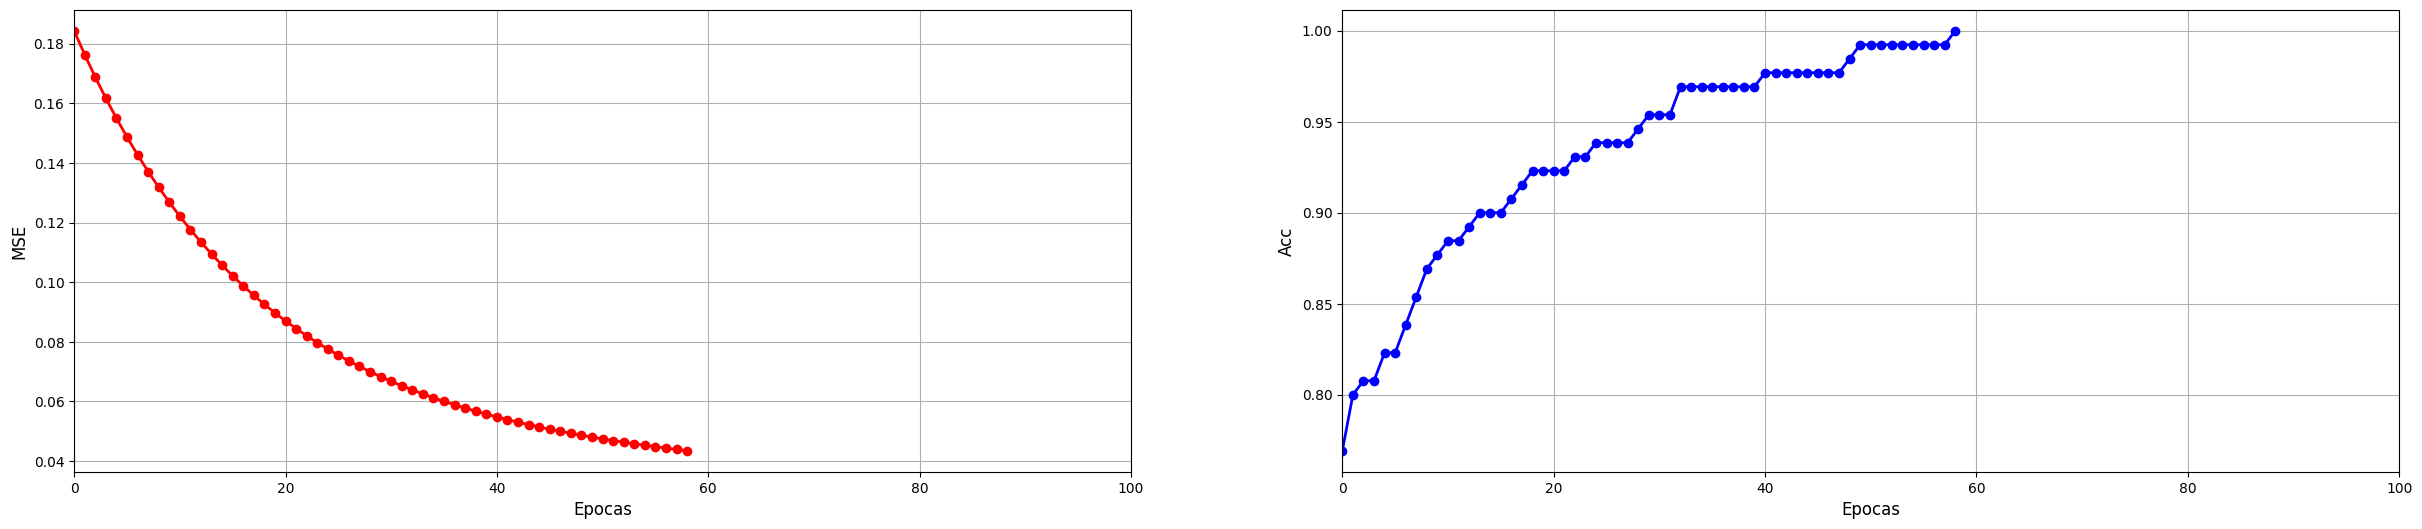

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(30,6))

epocas = np.arange(epoca)

# ERROR
ax[0].plot(epocas, error, 'o-r', lw=2)
ax[0].grid(True)
ax[0].set_xlim(0,MAX_EPOCAS)
ax[0].set_xlabel('Epocas', fontsize=12)
ax[0].set_ylabel('MSE', fontsize=12)

# ACC
ax[1].plot(epocas, accuracy, 'o-b', lw=2)
ax[1].grid(True)
ax[1].set_xlim(0,MAX_EPOCAS)
ax[1].set_xlabel('Epocas', fontsize=12)
ax[1].set_ylabel('Acc', fontsize=12)



---

## LECTURA DE DATOS DE EVALUACION

In [ ]:
#=====================================
# LEVANTAMOS DE DISCO EL MEJOR MODELO
#=====================================

del modelo  # Eliminamos de memoria
            # para asegurarnos de usar
            # el modelo guardado en disco

#--------------------------------------
# Modelo completo (archivo binario)
#--------------------------------------
modelo = torch.load('best_model.pt').to(device)

#-----------------------
# A partir de los pesos
#-----------------------
#best_model = torch.load('best_model_state_dict.pt')
#modelo = PERCEPTRON(n_features=2, lr=learning_rate)
#modelo.load_state_dict(best_model)
#modelo.to(device)

In [ ]:
#=====================================
# CONSTRUIMOS EL DATASET PARA TEST
#=====================================
tst = DATASET(filename_test_data)

test_data = DataLoader(tst, batch_size=1, shuffle=False)

#=====================================
# EVALUAMOS EL MODELO ENTRENADO
#=====================================
error,Y,Yp = predict_step(modelo, test_data, loss_function, device)
acc = torch.sum(Yp.sign() == Y.sign())/ len(Y)

print('\nTasa acierto [test]: {}\n'.format(acc))

## GRAFICAMOS LAS SALIDAS

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))

# CLASIFICACION

C = []
for i in range(len(Y)):
    if (np.sign(Y[i]) == np.sign(Yp[i])) and (Y[i] == 1):
        C.append('blue')
    if (np.sign(Y[i]) == np.sign(Yp[i])) and (Y[i] == -1):
        C.append('red')
    if (np.sign(Y[i]) != np.sign(Yp[i])) and (Y[i] == 1):
        C.append('cyan')
    if (np.sign(Y[i]) != np.sign(Yp[i])) and (Y[i] == -1):
        C.append('magenta')
        
ax.scatter(test_data.dataset.x[:,0], test_data.dataset.x[:,1], 20, C)

#-----------------------------------------------
# CONSTRUCCION DE LA FRONTERA DE DECISION
# CONSTRUCCION DE LA FRONTERA DE DECISION
x = torch.tensor([-1.5, 1.5])
W = modelo.fc.weight.flatten().detach().cpu()
B = modelo.fc.bias.detach().cpu()
b = -B/W[1]
m = W[0]/W[1]

ax.plot(x, b - m * x, '-k', lw=2)  # FRONTERA DE DECISION
ax.set_xlim(-1.1,1.1)
ax.set_ylim(-1.1,1.1)
ax.grid(True)